1. [Load Data](#load_data)
2. [Exploratory Data](#exploratory_data) <br>
2.1. [weet의 글자 개수, 단어 개수, 문장 개수의 분포](#eda_1) <br>
2.2. [Stopwords(불용어)의 차이가 있을까](#eda_2) <br>
2.3. [Wordcloud](#eda_3) <br>
3. [Text Cleaning](#text_cleansing) <br>
3.1. [Url 제거](#text_cleansing) <br>
3.2. [구두점 제거](#text_cleansing) <br>
3.3. [이모티콘 제거](#text_cleansing) <br>
3.4. [HTML tag 제거](#text_cleansing) <br>
3.5. [Stopwords 제거](#text_cleansing) <br>
3.6. [Lemmatization](#text_cleansing) <br>
4. [Make Dataset & Embedding Layer](#make_dataset) <br>
4.1. [Tokenization - 단어를 숫자로](#make_dataset1) <br>
4.2. [Padding - 모든 문장의 길이를 똑같이](#make_dataset2) <br>
4.3. [Embedding Matrix - Glove](#make_dataset3) <br>
5. [Data Split](#data_split) <br>    
6. [Modeling & Training](#modeling) <br>
6.1. [SimpleRNN](#modeling1) <br>
6.2. [LSTM](#modeling2) <br>
6.3. [LSTM with Attention](#modeling3) <br>
6.3. [Transformer](#modeling4) <br>
6.4. [BERT](#modeling5) <br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
%matplotlib inline
plt.style.use('ggplot')

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from string import punctuation
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

<a id='load_data'></a>
# 1. Load Data

In [2]:
tweets = pd.read_csv('./data/nlp-getting-started/train.csv')
test = pd.read_csv('./data/nlp-getting-started/test.csv')
tweets.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [3]:
tweets.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

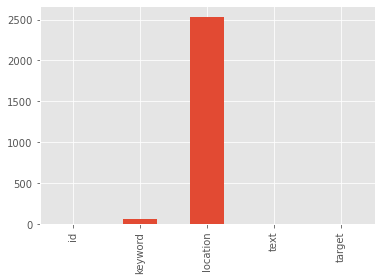

In [8]:
# 각 행의 null 개수 확인 
tweets.isnull().sum().plot(kind='bar')

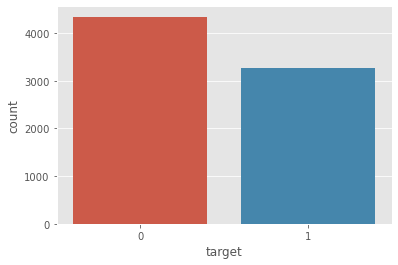

In [9]:
# 종속변수 개수 확인
sns.countplot('target', data=tweets)

<a id='exploratory_data'></a>
# 2. Exploratory Data

In [11]:
tweets.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


<a id='eda_1'></a>
### 2.1  tweet의 글자 개수, 단어 개수, 문장 개수의 분포

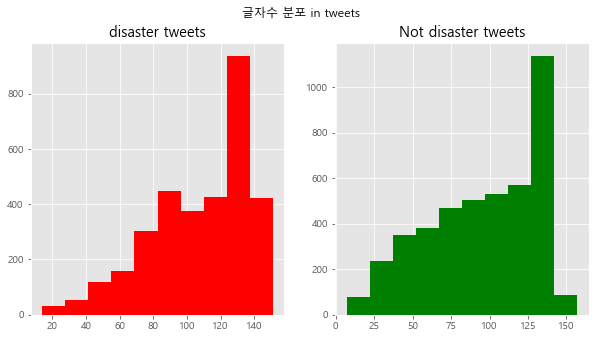

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

# 재난 tweet의 각각의 글자 수
tweet_len=tweets[tweets['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

# 비재난 tweet의 각각의 글자 수
tweet_len=tweets[tweets['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('글자수 분포 in tweets')
plt.show()

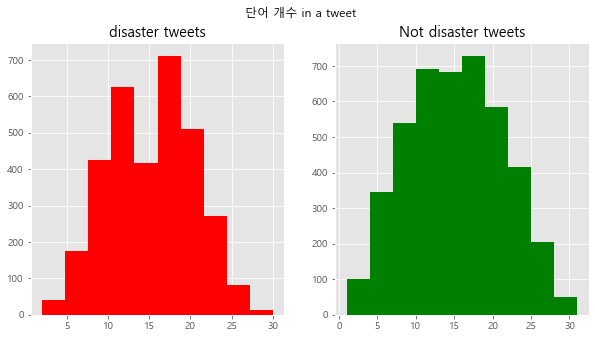

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len=tweets[tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=tweets[tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('단어 개수 in a tweet')
plt.show()

영어는 띄어쓰기를 기준으로 단어가 나누어지므로 위의 방식처럼 split()을 사용해도 되고 아래 방식처럼 nltk의 word_tokneize를 사용할 수 있다. 

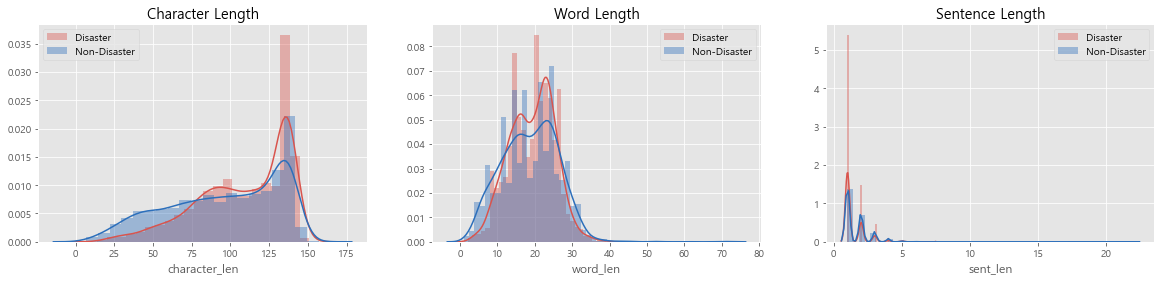

In [88]:
# 글자 개수
tweets['character_len'] = tweets.text.str.len()

# 단어 개수
word_len = [len(word_tokenize(tweet)) for tweet in tweets.text]
tweets['word_len'] = word_len

# 문장 개수 
sent_len = [len(sent_tokenize(tweet)) for tweet in tweets.text]
tweets['sent_len'] = sent_len

plot_cols = ['character_len','word_len','sent_len']
plot_titles = ['Character Length','Word Length','Sentence Length']

plt.figure(figsize=(20,4))
for counter, i in enumerate([0,1,2]):
    plt.subplot(1,3,counter+1)
    sns.distplot(tweets[tweets.target == 1][plot_cols[i]], label='Disaster', color=color[1]).set_title(plot_titles[i])
    sns.distplot(tweets[tweets.target == 0][plot_cols[i]], label='Non-Disaster', color=color[0])
    plt.legend()

In [33]:
tweets.head(2)

,id,keyword,location,text,target,character_len,word_len,sent_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,14,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,8,2


<a id='eda_2'></a>
### 2.2 Stopwords(불용어)의 차이가 있을까

In [3]:
# set(stopwords.words('english')) 으로 영어 불용어 사전을 만들 수 있다. 
stop = set(stopwords.words('english'))
#stop

[('the', 1888), ('i', 1370), ('a', 1254), ('to', 1188), ('and', 916), ('of', 901), ('in', 818), ('you', 739), ('is', 604), ('my', 542)]
('the', 1888) ('i', 1370) ('a', 1254) ('to', 1188) ('and', 916) ('of', 901) ('in', 818) ('you', 739) ('is', 604) ('my', 542)
[('the', 1345), ('in', 1159), ('a', 925), ('of', 921), ('to', 757), ('and', 502), ('on', 417), ('for', 400), ('is', 363), ('i', 360)]
('the', 1345) ('in', 1159) ('a', 925) ('of', 921) ('to', 757) ('and', 502) ('on', 417) ('for', 400) ('is', 363) ('i', 360)


Text(0.5, 1.0, 'Top stopwords for Disaster')

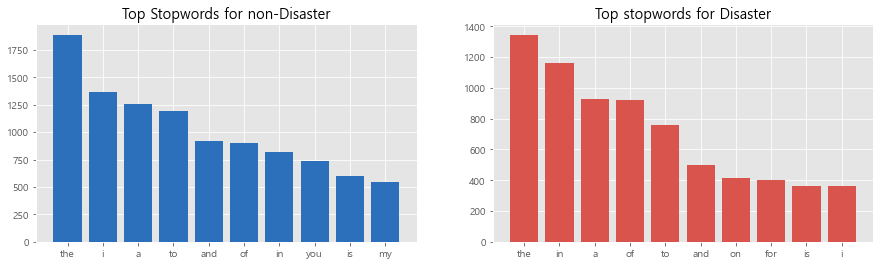

In [66]:
corpus0 = [] # target이 0인 문장의 모든 단어들을 담는다
[corpus0.append(word.lower()) for tweet in tweets[tweets.target == 0].text for word in word_tokenize(tweet)]
corpus1 = [] # target이 1인 문장의 모든 단어들을 담는다
[corpus1.append(word.lower()) for tweet in tweets[tweets.target == 1].text for word in word_tokenize(tweet)]


def count_stopwords(corpus):
    stopwords_freq = {}
    for word in corpus:
        if word in stop:                 # 그 단어가 불용어 사전에 있으면
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1
    # 빈도 순으로 상위 10개만 추출
    topwords = sorted(stopwords_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    print(topwords)
    print(*topwords)
    x,y = zip(*topwords)
    return x,y

x0,y0 = count_stopwords(corpus0)
x1,x2 = count_stopwords(corpus1)

color = [sns.xkcd_rgb['medium blue'], sns.xkcd_rgb['pale red']]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0,color=color[0])
plt.title('Top Stopwords for non-Disaster')

plt.subplot(1,2,2)
plt.bar(x1,x2,color=color[1])
plt.title('Top stopwords for Disaster')

<a id='eda_3'></a>
### 2.3 Wordcloud

Text(0.5, 1.0, 'Distaset')

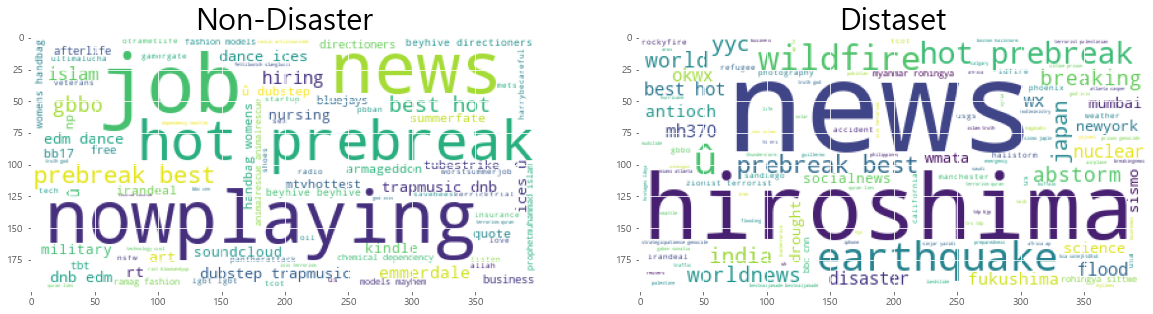

In [86]:
def clean(word):
    for p in punctuation: 
        word = word.replace(p, '')
    return word
        
def make_wordcloud(target):
    # "#"로 시작하는  모든 단어들 추출
    hashtag = [clean(w[1:].lower()) for tweet in tweets[tweets.target == target].text for w in tweet.split() if '#' in w and w[0] == '#']
    hashtag = ' '.join(hashtag)
    # wordcloud 객체를 만들고 hashtag를 담은 리스트로 생성하기
    wc = WordCloud(background_color='white', stopwords=stop).generate(hashtag)
    
    plt.subplot(1,2,target+1)
    plt.imshow(wc)
    
plt.figure(figsize=(20,15))
make_wordcloud(0)
plt.title('Non-Disaster', fontsize=30)
make_wordcloud(1)
plt.title('Distaset', fontsize=30)

<a id='text_cleansing'></a>
# 3. Text Cleaning
- Remove URLs
- Remove Punctuations except '!?'
- Remove Emojis
- Remove HTML tags
- Remove Stopwords
- 축약형을 풀어주기 - won't를 will not으로
- Lemmatization 표제어 - 활용어(inflected words)를 root단어로 바꾸기
<br>
<대게 어간추출(steming)과 표제어 추출의 목표는 서로 다른 단어들이지만, 하나의 단어로 일반화시켜서 문서 내의 단어 수를 줄이는 것으로 볼 수 있다. 그 중 Lemmatization의 한 예시는 am,are,is -> be동사로 바꿔주는 것이있다.>

In [3]:
df = pd.concat([tweets,test])
print(tweets.shape)
print(test.shape)
print(df.shape)

(7613, 5)
(3263, 4)
(10876, 5)


In [4]:
##### remove URLs
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
df.text = df.text.apply(lambda x: remove_url(x))

stop = set(stopwords.words('english'))
##### remove Punctuations except !?
def remove_punct(text):
    new_punct = re.sub('\ |\!|\?', '', punctuation)
    table=str.maketrans('','',new_punct)
    return text.translate(table)
df.text = df.text.apply(lambda x: remove_punct(x))


##### Remove Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df.text = df.text.apply(lambda x: remove_emoji(x))


##### Remove HTML tags
def remove_html(text):
    # . 은 \n(엔터)을 제외한 모든 문자와 매치 (점 하나는 글자 하나를 의미)
    # * 은 0회 이상 반복(없어도 상관 없음)
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
df.text = df.text.apply(lambda x: remove_html(x))


##### Remove Stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    return ' '.join([w.lower() for w in word_tokens if not w.lower() in stop])
df['text_nostopwords'] = df.text.apply(lambda x: remove_stopwords(x))



##### 축약형을 풀어주기 - won't를 will not으로
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df.text = [decontraction(tweet) for tweet in df.text]



##### Lemmatization 표제어 - 활용어(inflected words)를 root단어로 바꾸기
# 위에서 stop = set(stopwords.words('english'))로 불용어 사전을 만들어 두었음
lemmatizer = WordNetLemmatizer()
def lemma(text):
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w.lower(), pos='v') for w in words])
df.text = df.text.apply(lambda x: lemma(x))

In [90]:
lemmatizer.lemmatize('watched', 'v')

'watch'

In [7]:
df.text.head(3)

0    our deeds be the reason of this earthquake may...
1                forest fire near la ronge sask canada
2    all residents ask to shelter in place be be no...
Name: text, dtype: object

<a id='make_dataset'></a>
# 4. Make Dataset & Embedding Layer 

<a id='make_dataset1'></a>
### 4.1 Tokenization - 단어를 숫자로

In [5]:
def create_corpus(df):
    corpus = []
    for tweet in df['text']:
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1))]
        corpus.append(words)
    return corpus

corpus = create_corpus(df)

In [6]:
max_len = 50
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

In [7]:
word_index = tokenizer.word_index
print('number of unique words: ', len(word_index))

number of unique words:  18468


<a id='make_dataset2'></a>
### 4.2 Padding - 모든 문장의 길이를 똑같이

In [8]:
tweet_pad = pad_sequences(sequences, maxlen=max_len, padding='post')

In [9]:
# pad_sequences 로 모든 문장의 길이를 max_len으로 맞춰주기 
tweet_pad[0]

array([ 112, 4748,    2,    1,  539,    6,   19,  284,  160, 1858, 1859,
         70,   41,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

<a id='make_dataset3'></a>
### 4.3 Embedding Matrix - Glove
<br>
미리 훈련된 Glove를 사용할 것이고 200차원으로 표현되어있다. 

In [9]:
# load the whole embedding
embedding_dict = dict()
f = open('./word_embedding/glove.twitter.27B.200d.txt','rt', encoding='UTF8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embedding_dict))

Loaded 1193515 word vectors.


In [10]:
# 0 인덱스를 포함해야 하므로 1을 더해준다.
# tweet에 있는 전체 단어 개수만큼의 행과 100차원(열)을 매트릭스로 표현
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 200))

for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('enbedding matrix shape: ', embedding_matrix.shape)

enbedding matrix shape:  (18469, 200)


In [12]:
# 각 행은 단어 하나를 의미하고 이들의 200차원 단어 벡터값을 보여준다. 
len(embedding_matrix[1])

200

<a id='data_split'></a>
# 5. Data Split

In [10]:
# train과 test를 분리해줌
train = tweet_pad[:tweets.shape[0]]
test = tweet_pad[tweets.shape[0]:]

In [11]:
# train에 대해서도 학습용과 검증용으로 분리

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train,tweets['target'].values,test_size=0.15)

In [12]:
X_train

array([[  806,   300,  1185, ...,     0,     0,     0],
       [ 1120,   490,   124, ...,     0,     0,     0],
       [   54,  3411,  4060, ...,     0,     0,     0],
       ...,
       [    1,   246,    48, ...,     0,     0,     0],
       [10891, 10892,   584, ...,     0,     0,     0],
       [   31,  1120,     2, ...,     0,     0,     0]])

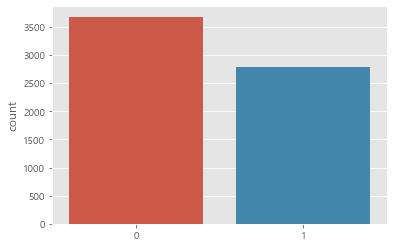

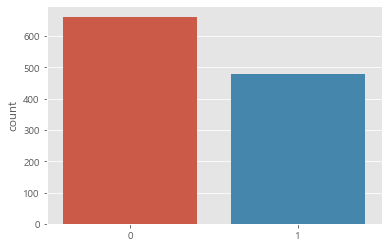

In [14]:
sns.countplot(y_train)
plt.show()
sns.countplot(y_test)
plt.show()

<a id='modeling'></a>
# 6. Modeling & Training

<a id='modeling1'></a>
## 6.1 SimpleRNN

In [14]:
import numpy as np  
from tensorflow.keras.preprocessing import sequence 
from tensorflow.keras.models import Sequential     
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SimpleRNN, Embedding, LSTM

In [15]:
def plot_model_performance(history):   
    plt.figure(figsize=(15,5))
    plt.plot(range(num_epochs), history.history['accuracy'],'-o',
             label='Train ACC',color='#ff7f0e')
    plt.plot(range(num_epochs),history.history['val_accuracy'],'-o',
             label='Val ACC',color='#1f77b4')
    x = np.argmax( history.history['val_accuracy'] ); y = np.max( history.history['val_accuracy'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
    plt.ylabel('Accuracy',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=(0.01,0.75))

    plt2 = plt.gca().twinx()
    plt2.plot(range(num_epochs),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    plt2.plot(range(num_epochs),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
   # plt.ylim([-0.2, 2])
    plt.ylabel('Loss',size=14)
    plt.xticks(ticks=list(range(num_epochs)),labels=list(range(1, num_epochs+1)))
    plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1))
    plt.show()

In [37]:
num_neurons = 50
embedding=Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(SimpleRNN(num_neurons, return_sequences=True, input_shape=(max_len, 200)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           3693800   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50, 50)            12550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2501      
Total params: 3,708,851
Trainable params: 15,051
Non-trainable params: 3,693,800
_________________________________________________________________


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 - 58s - loss: 0.4886 - accuracy: 0.7803 - val_loss: 0.5906 - val_accuracy: 0.7636
Epoch 2/15
6471/6471 - 54s - loss: 0.4374 - accuracy: 0.8036 - val_loss: 0.5346 - val_accuracy: 0.7802
Epoch 3/15
6471/6471 - 57s - loss: 0.4002 - accuracy: 0.8246 - val_loss: 0.4935 - val_accuracy: 0.7828
Epoch 4/15
6471/6471 - 60s - loss: 0.3638 - accuracy: 0.8439 - val_loss: 0.5550 - val_accuracy: 0.7846
Epoch 5/15
6471/6471 - 61s - loss: 0.3231 - accuracy: 0.8634 - val_loss: 0.6161 - val_accuracy: 0.7776
Epoch 6/15
6471/6471 - 58s - loss: 0.2948 - accuracy: 0.8798 - val_loss: 0.6417 - val_accuracy: 0.7627
Epoch 7/15
6471/6471 - 60s - loss: 0.2699 - accuracy: 0.8929 - val_loss: 0.6998 - val_accuracy: 0.7750
Epoch 8/15
6471/6471 - 57s - loss: 0.2424 - accuracy: 0.9076 - val_loss: 0.7334 - val_accuracy: 0.7644
Epoch 9/15
6471/6471 - 60s - loss: 0.2262 - accuracy: 0.9141 - val_loss: 0.8127 - val_accuracy: 0.7364
Epoch 10/15
6471/6471 - 6

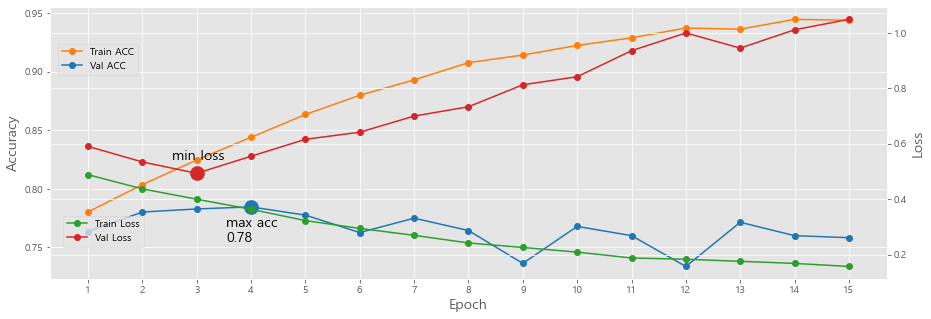

In [41]:
num_epochs = 15
history = model.fit(X_train, y_train, batch_size=4, epochs=15, validation_data=(X_test,y_test),verbose=2)
plot_model_performance(history)

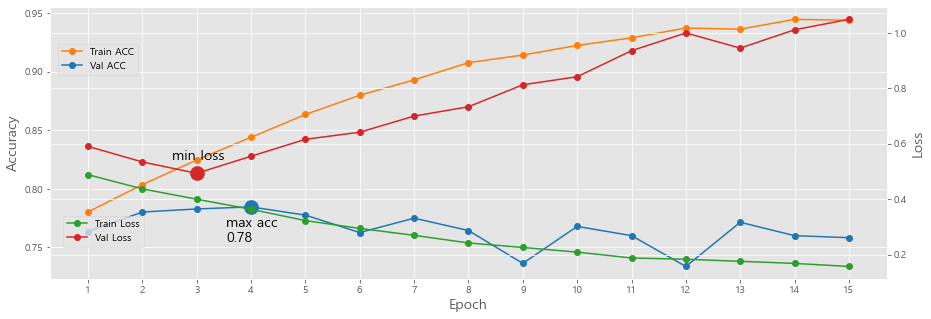

In [44]:
plot_model_performance(history)

<a id='modeling2'></a>
## 6.2 LSTM

In [50]:
num_neurons = 50
embedding=Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(max_len, 200)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 200)           3693800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 50)            50200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2501      
Total params: 3,746,501
Trainable params: 52,701
Non-trainable params: 3,693,800
_________________________________________________________________


In [51]:
num_epochs = 4
history = model.fit(X_train, y_train, batch_size=4, epochs=num_epochs, validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/4
6471/6471 - 86s - loss: 0.4755 - accuracy: 0.7832 - val_loss: 0.4254 - val_accuracy: 0.8214
Epoch 2/4
6471/6471 - 81s - loss: 0.4090 - accuracy: 0.8258 - val_loss: 0.4436 - val_accuracy: 0.8117
Epoch 3/4
6471/6471 - 78s - loss: 0.3641 - accuracy: 0.8473 - val_loss: 0.4571 - val_accuracy: 0.8074
Epoch 4/4
6471/6471 - 78s - loss: 0.3145 - accuracy: 0.8719 - val_loss: 0.4904 - val_accuracy: 0.8135


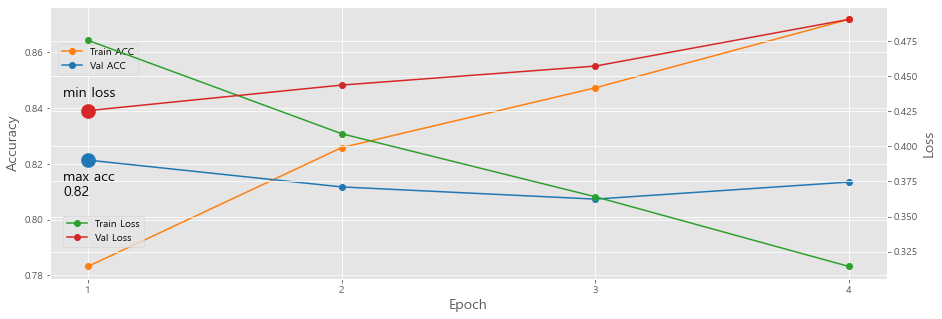

In [52]:
plot_model_performance(history)

<a id='modeling3'></a>
## 6.3 LSTM with Attention

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding,Flatten, Input, Layer, GlobalMaxPooling1D, LSTM, Bidirectional, Concatenate,Activation, Dropout, Dense
from tensorflow.keras import optimizers

In [54]:
## Embedding Layer
sequence_input = Input(shape=(max_len,))
embedded_sequences = Embedding(num_words, 200, weights=[embedding_matrix], trainable=False)(sequence_input)

## RNN Layer
lstm = Bidirectional(LSTM(128, return_sequences = True, dropout=0.3, recurrent_dropout=0.3))(embedded_sequences)
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional\
(LSTM(128, return_sequences=True, return_state=True))(lstm)

**바다나우 어텐션을 이용**

In [55]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [56]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(128) # 가중치 크기 정의

# 어텐션 메커니즘에서는 은닉 상태를 사용한다. state_h를 입력으로 컨텍스트 벡터를 얻음
context_vector, attention_weights = attention(lstm, state_h)

In [57]:
# 위의 컨텍스트 벡터를 밀집층에 통과시키고, 
#이진 분류이므로 최종 출력층에 1개의 뉴련 배치, 활성화 함수로 시그모이드 함수를 사용
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(sequence_input, output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 200)      3693800     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 256)      336896      embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 50, 256), (N 394240      bidirectional_2[0][0]            
____________________________________________________________________________________________

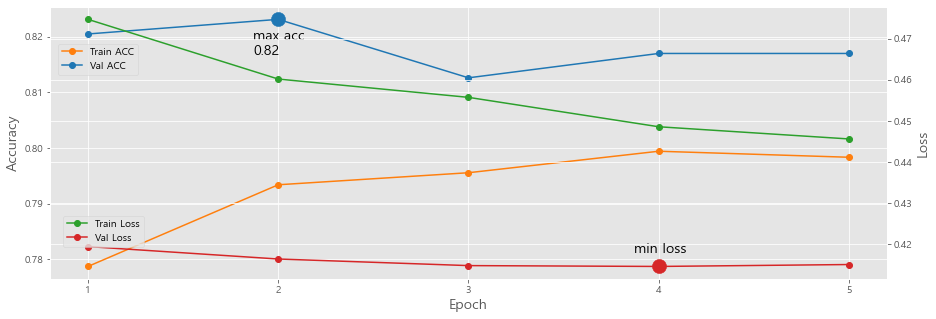

In [40]:
num_epochs = 5
plot_model_performance(histoy)

<a id='modeling4'></a>
## 6.4 Transformer

멀티 헤드 어텐션

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

인코더 설계하기

In [18]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

포지션 임베딩

In [19]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [20]:
X_train

array([[ 8678,    25,    14, ...,     0,     0,     0],
       [12290, 12291,  1914, ...,     0,     0,     0],
       [   19,     2,     3, ...,     0,     0,     0],
       ...,
       [    8,    12,    44, ...,     0,     0,     0],
       [    9,  3192,   193, ...,     0,     0,     0],
       [  159,     4,   643, ...,     0,     0,     0]])

In [25]:
embedding_dim = 200 
num_heads = 2  
dff = 32  

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, num_words, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', \
              optimizer='adam', metrics=['accuracy'])

In [27]:
num_epochs = 5
histoy = model.fit(X_train, y_train, batch_size=32, epochs=num_epochs, validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/5
6471/6471 - 25s - loss: 0.3652 - accuracy: 0.8513 - val_loss: 0.5069 - val_accuracy: 0.7820
Epoch 2/5
6471/6471 - 25s - loss: 0.2048 - accuracy: 0.9272 - val_loss: 0.5800 - val_accuracy: 0.7750
Epoch 3/5
6471/6471 - 28s - loss: 0.1112 - accuracy: 0.9587 - val_loss: 0.8342 - val_accuracy: 0.7644
Epoch 4/5
6471/6471 - 28s - loss: 0.0641 - accuracy: 0.9742 - val_loss: 1.3334 - val_accuracy: 0.7653
Epoch 5/5
6471/6471 - 25s - loss: 0.0587 - accuracy: 0.9750 - val_loss: 0.9943 - val_accuracy: 0.7785


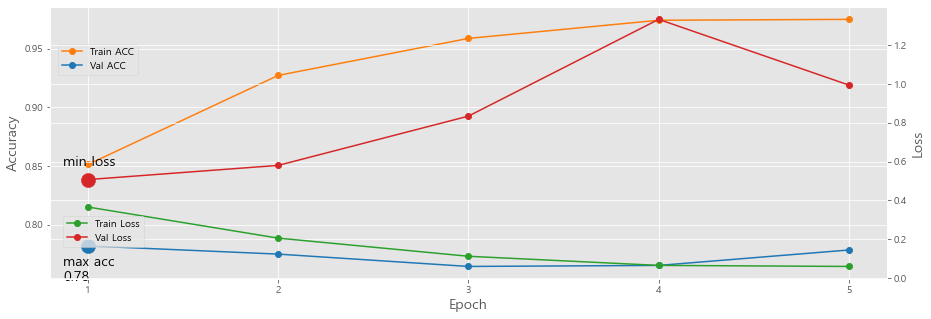

In [32]:
plot_model_performance(histoy)

<a id='modeling5'></a>
## 6.5 BERT

In [23]:
# Hyperparameters
maxlen = 160
lr = 1e-5 # 1e-5 
num_epochs = 3 # 5
batch_size=16 # batch size cannot be too big for bert

In [24]:
import tensorflow as tf
tf.gfile = tf.io.gfile
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#import tokenization
from bert import tokenization

In [25]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [26]:
def build_model(bert_layer, max_len=512, lr=1e-5):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [27]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Wall time: 42.6 s


text 리뷰가 있는 원본 데이터로 다시 split해서 인수에 넣어야한다!

In [28]:
df_train = df[:tweets.shape[0]]
df_test = df[tweets.shape[0]:]

from sklearn.model_selection import train_test_split
df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_train.drop(['id','keyword','location','target'],axis=1), df_train[['target']], test_size=0.2, stratify=tweets[['target']], random_state=0)
print('X_train shape: ', df_X_train.shape)
print('X_val shape: ', df_X_val.shape)
print('y_train shape: ', df_y_train.shape)
print('y_val shape: ', df_y_val.shape)

X_train shape:  (6090, 2)
X_val shape:  (1523, 2)
y_train shape:  (6090, 1)
y_val shape:  (1523, 1)


In [30]:
train_input = bert_encode(df_X_train.text.values, tokenizer, max_len=maxlen)
val_input = bert_encode(df_X_val.text.values, tokenizer, max_len=maxlen)
train_labels = df_y_train.target.values
val_labels = df_y_val.target.values

In [22]:
bert_model = build_model(bert_layer, max_len=maxlen, lr=lr)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [23]:
bert_model = build_model(bert_layer, max_len=maxlen, lr=lr)
checkpoint = ModelCheckpoint('bertmodel.h5', monitor='val_accuracy', save_best_only=True)

bert_history = bert_model.fit(
    train_input, train_labels,
    validation_data=(val_input, val_labels),
    epochs=1,
    callbacks=[checkpoint], 
    #class_weight=class_weight,
    batch_size=batch_size
)

Train on 6090 samples, validate on 1523 samples
6090/6090 [==============================] - 21369s 4s/sample - loss: 0.4387 - accuracy: 0.8028 - val_loss: 0.3904 - val_accuracy: 0.8385
